In [3]:
import fasttext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import FastText
from gensim.models import Word2Vec
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


In [4]:
# ----------------------------------------------
#               PREPARE DATASET
# ----------------------------------------------

# get the recipe health scores from another csv file then merge with our df
# new df --> recipeName | ingredient
recipes = pd.read_csv('recipes_v4.csv')  
recipes = recipes.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
recipe_ingredient_tuples = recipes.groupby('Recipe')['Ingredient'].agg(list).reset_index(name='ingredient')
recipe_ingredient_tuples.columns = ['recipe', 'ingredient']

# get the recipe health scores from another csv file then merge with our df
# new df --> recipeName | ingredient | USDAScore | FSAScore
recipe_score_data=pd.read_csv('recipes-scores.csv')  
full_dataframe=recipe_ingredient_tuples.merge(recipe_score_data,how="left",on='recipe')
full_dataframe.drop_duplicates(subset="recipe", keep=False, inplace=True)

# Create Binary labels for USDA and FSA scores
full_dataframe['USDAlabel'] = [1 if score>4 else 0 for score in full_dataframe['USDAscore']]
full_dataframe['FSAlabel'] = [1 if score>4 else 0 for score in full_dataframe['FSAscore']]

In [5]:
# ----------------------------------------------
#    BUILD W2V MODEL, DERIVE TEST/TRAIN DATA
# ----------------------------------------------

w2v_data = full_dataframe

model = Word2Vec(w2v_data['ingredient'], vector_size=100, window=5, min_count=5, workers=4, epochs=50)

print(model.wv.most_similar("sugar", topn=10))

def get_recipe_vector(recipe):
    vectors = [model.wv[word.strip()] for word in recipe]
    return np.mean(vectors, axis=0)

w2v_data['mean_vector'] = w2v_data['ingredient'].apply(get_recipe_vector)

# Split the data into training and test sets
train_data = w2v_data.sample(frac=0.7, random_state=1)
test_data = w2v_data.drop(train_data.index)

[('white sugar', 0.6104656457901001), ("confectioners' sugar", 0.5622157454490662), ('brown sugar', 0.48593848943710327), ('marzipan', 0.4456421434879303), ('stevia powd', 0.4397779107093811), ('sucrolose sweeten', 0.4295015335083008), ('artificial sweeten', 0.4196012616157532), ('white chocol', 0.41592296957969666), ('vanilla bean past', 0.39832165837287903), ('cinnamon sugar', 0.3940149247646332)]


W2V FSA label Accuracy: 0.6970552642194433


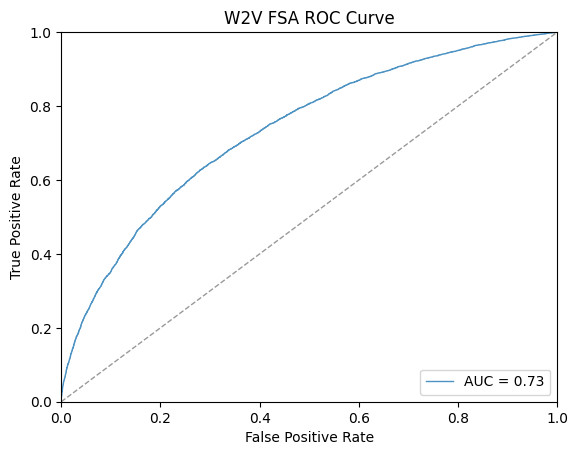

In [6]:
# ----------------------------------------------
#           TEST W2V WITH USDA
# ----------------------------------------------

# fit a logistic regression model on the training data
w2v_model = LogisticRegression(max_iter=2000)
w2v_model.fit(train_data['mean_vector'].tolist(), train_data['FSAlabel'])

# Evaluate the model on the test data
w2v_accuracy = w2v_model.score(test_data['mean_vector'].tolist(), test_data['FSAlabel'])
print(f"W2V FSA label Accuracy: {w2v_accuracy}")

# predict the target probabilities on the test data
probas = w2v_model.predict_proba(test_data['mean_vector'].tolist())

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_data['FSAlabel'], probas[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('W2V FSA ROC Curve')
plt.legend(loc="lower right")
plt.show()

W2V FSA label Accuracy: 0.7829770068576039


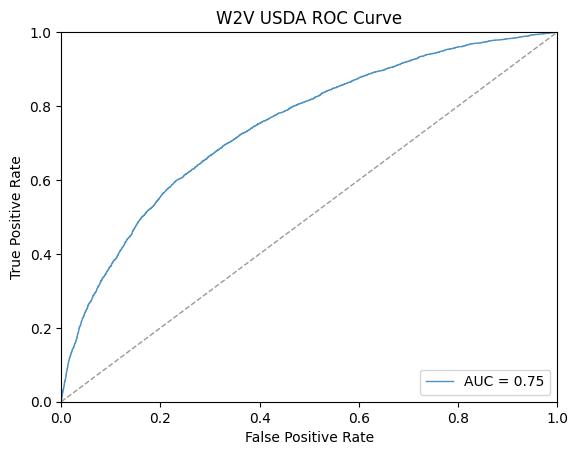

In [7]:
# ----------------------------------------------
#           TEST W2V WITH USDA
# ----------------------------------------------

# fit a logistic regression model on the training data
w2v_model = LogisticRegression(max_iter=2000)
w2v_model.fit(train_data['mean_vector'].tolist(), train_data['USDAlabel'])

# Evaluate the model on the test data
w2v_accuracy = w2v_model.score(test_data['mean_vector'].tolist(), test_data['USDAlabel'])
print(f"W2V FSA label Accuracy: {w2v_accuracy}")

# predict the target probabilities on the test data
probas = w2v_model.predict_proba(test_data['mean_vector'].tolist())

# evaluate the performance of the model using ROC AUC score
# auc = roc_auc_score(test_data['USDAlabel'], probas[:, 1])
# print('ROC AUC score:', auc)

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_data['USDAlabel'], probas[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('W2V USDA ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
# ----------------------------------------------
#     BUILD FT MODEL, DERIVE TEST/TRAIN DATA
# ----------------------------------------------

std_fasttext_data = full_dataframe

# prepare input file for fasttext
with open('fast_text_input.txt','w+') as file:
    for row in std_fasttext_data['ingredient']:
        row = [item.replace(' ','-') for item in row]
        file.write(' '.join(row) + '\n')

# train fasttext model using two different algorithms
standard_model = fasttext.train_unsupervised('./fast_text_input.txt')

# test basic similarity search results
print("Basic similarity search on sugar:")
print(standard_model.get_nearest_neighbors('sugar', 6))

# converts an ingredient string to a feature vector
def ingredient_to_vector(ingredient):
    return standard_model.get_word_vector(ingredient)

# Convert each ingredient in each recipe to a feature vector
std_fasttext_data['features'] = std_fasttext_data['ingredient'].apply(lambda x: [ingredient_to_vector(ingredient) for ingredient in x])

# Compute the mean feature vector for each recipe
std_fasttext_data['mean_vector'] = std_fasttext_data['features'].apply(lambda x: np.mean(x, axis=0))

# Split the data into training and test sets
train_data = std_fasttext_data.sample(frac=0.7, random_state=1)
test_data = std_fasttext_data.drop(train_data.index)


Read 0M words
Number of words:  964
Number of labels: 0
Progress: 100.0% words/sec/thread:  271400 lr:  0.000000 avg.loss:  2.372918 ETA:   0h 0m 0s


Basic similarity search on sugar:
[(0.9226816296577454, 'white-sugar'), (0.8619422912597656, 'cinnamon-sugar'), (0.8475675582885742, 'vanilla-sugar'), (0.8165849447250366, "confectioners'-sugar"), (0.7905667424201965, 'brown-sugar'), (0.785452127456665, 'stevia')]


USDA label Accuracy: 0.7727410246066962


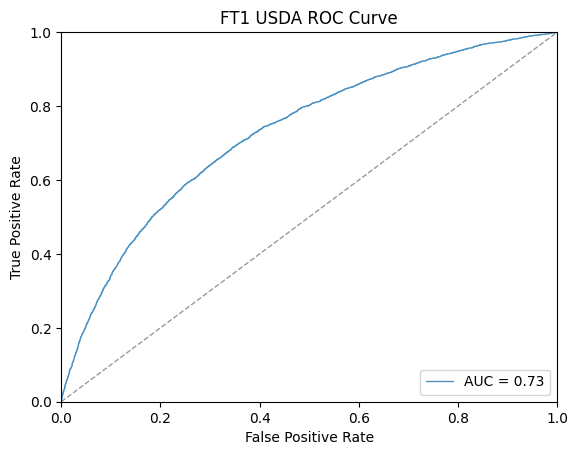

In [9]:
# ----------------------------------------------
#           TEST FT WITH USDA
# ----------------------------------------------

# Train a logistic regression model on the mean feature vectors
USDA_log_regression_model = LogisticRegression(max_iter=2000)
USDA_log_regression_model.fit(train_data['mean_vector'].tolist(), train_data['USDAlabel'])

# Evaluate the model on the test data
USDA_accuracy = USDA_log_regression_model.score(test_data['mean_vector'].tolist(), test_data['USDAlabel'])
print(f"USDA label Accuracy: {USDA_accuracy}")

# Predict probabilities
probas = USDA_log_regression_model.predict_proba(test_data['mean_vector'].tolist())

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_data['USDAlabel'], probas[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FT1 USDA ROC Curve')
plt.legend(loc="lower right")
plt.show()


FSA label Accuracy: 0.6794070189592578


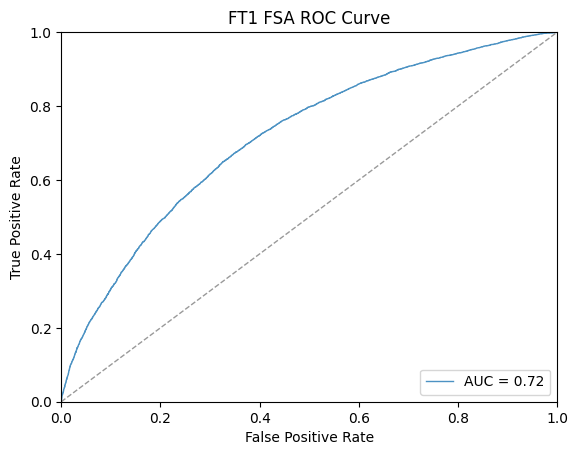

In [10]:
# ----------------------------------------------
#           TEST FT WITH FSA
# ----------------------------------------------

# Train a logistic regression model on the mean feature vectors
FSA_log_regression_model = LogisticRegression(max_iter=2000)
FSA_log_regression_model.fit(train_data['mean_vector'].tolist(), train_data['FSAlabel'])

# Train a logistic regression model on the mean feature vectors
FSA_log_regression_model = LogisticRegression(max_iter=2000)
FSA_log_regression_model.fit(train_data['mean_vector'].tolist(), train_data['FSAlabel'])

# Evaluate the model on the test data
FSA_accuracy = FSA_log_regression_model.score(test_data['mean_vector'].tolist(), test_data['FSAlabel'])
print(f"FSA label Accuracy: {FSA_accuracy}")

# Predict probabilities
probas = FSA_log_regression_model.predict_proba(test_data['mean_vector'].tolist())

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_data['FSAlabel'], probas[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FT1 FSA ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# ----------------------------------------------
# BUILD GENSIM FT MODEL, DERIVE TEST/TRAIN DATA
# ----------------------------------------------

gensim_fasttext_data = full_dataframe

gensim_model = FastText(gensim_fasttext_data['ingredient'], vector_size=100, window=5, min_count=1, sg=1, epochs=10)

print("Basic similarity search on sugar:")
print(gensim_model.wv.most_similar(positive=['sugar'], topn=5))

# Compute the mean values for each recipe
gensim_fasttext_data['mean_value'] = gensim_fasttext_data['ingredient'].apply(lambda x: np.mean([gensim_model.wv[word] for word in x if word in gensim_model.wv], axis=0))

# Split the data into training and test sets
train_data = gensim_fasttext_data.sample(frac=0.7, random_state=1)
test_data = gensim_fasttext_data.drop(train_data.index)


Basic similarity search on sugar:
[('cinnamon sugar', 0.7044466733932495), ('vanilla sugar', 0.6836867928504944), ('white sugar', 0.6473288536071777), ("confectioners' sugar", 0.6174032688140869), ('stevia', 0.6121743321418762)]


FSA label Accuracy: 0.6794070189592578
[[0.15584429 0.84415571]
 [0.79241841 0.20758159]
 [0.56522288 0.43477712]
 ...
 [0.59458855 0.40541145]
 [0.69347809 0.30652191]
 [0.5757023  0.4242977 ]]


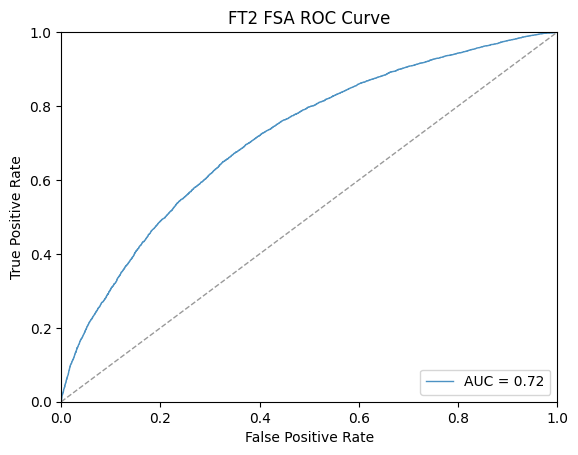

In [13]:
# ----------------------------------------------
#           TEST GENSIM FT WITH FSA
# ----------------------------------------------

# Train a logistic regression model on the mean feature vectors
FSA_log_regression_model = LogisticRegression(max_iter=2000)
FSA_log_regression_model.fit(train_data['mean_vector'].tolist(), train_data['FSAlabel'])

# Evaluate the model on the test data
FSA_accuracy = FSA_log_regression_model.score(test_data['mean_vector'].tolist(), test_data['FSAlabel'])
print(f"FSA label Accuracy: {FSA_accuracy}")

# Predict probabilities
probas = FSA_log_regression_model.predict_proba(test_data['mean_vector'].tolist())

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_data['FSAlabel'], probas[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FT2 FSA ROC Curve')
plt.legend(loc="lower right")
plt.show()

USDA label Accuracy: 0.7727410246066962
[[0.63293119 0.36706881]
 [0.84918533 0.15081467]
 [0.79880052 0.20119948]
 ...
 [0.91402618 0.08597382]
 [0.86828294 0.13171706]
 [0.82581736 0.17418264]]


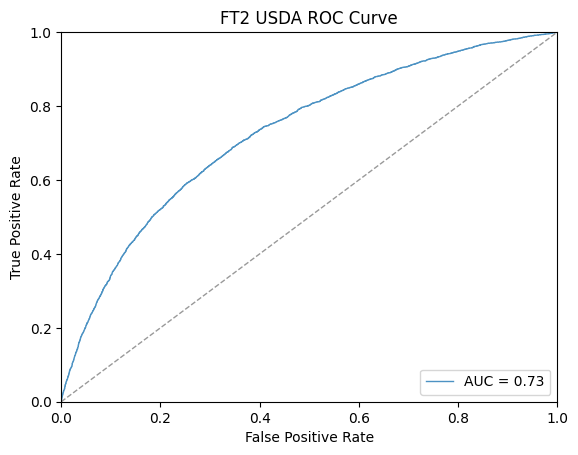

In [14]:
# ----------------------------------------------
#           TEST GENSIM FT WITH USDA
# ----------------------------------------------

# Train a logistic regression model on the mean feature vectors
USDA_log_regression_model = LogisticRegression(max_iter=2000)
USDA_log_regression_model.fit(train_data['mean_vector'].tolist(), train_data['USDAlabel'])

# Evaluate the model on the test data
USDA_accuracy = USDA_log_regression_model.score(test_data['mean_vector'].tolist(), test_data['USDAlabel'])
print(f"USDA label Accuracy: {USDA_accuracy}")

# Predict probabilities
probas = USDA_log_regression_model.predict_proba(test_data['mean_vector'].tolist())

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_data['USDAlabel'], probas[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FT2 USDA ROC Curve')
plt.legend(loc="lower right")
plt.show()